In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
train_data = pd.read_csv('/kaggle/input/train-and-test-data/train.csv')
test_data = pd.read_csv('/kaggle/input/train-and-test-data/test.csv')

In [22]:
train_data.shape

(7352, 563)

In [23]:
test_data.shape

(2947, 563)

In [24]:
data = pd.concat([train_data, test_data], axis=0)

In [25]:
data = data.drop(data.columns[-2], axis=1)

In [26]:
data.head

<bound method NDFrame.head of       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.288585          -0.020294          -0.132905   
1              0.278419          -0.016411          -0.123520   
2              0.279653          -0.019467          -0.113462   
3              0.279174          -0.026201          -0.123283   
4              0.276629          -0.016570          -0.115362   
...                 ...                ...                ...   
2942           0.310155          -0.053391          -0.099109   
2943           0.363385          -0.039214          -0.105915   
2944           0.349966           0.030077          -0.115788   
2945           0.237594           0.018467          -0.096499   
2946           0.153627          -0.018437          -0.137018   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.995279         -0.983111         -0.913526         -0.995112   
1            -0.998245       

In [27]:
len(set(data.columns.tolist()))

562

In [28]:
print(data.columns[330])
print(data.columns[316])
print(data.columns[302])

fBodyAcc-bandsEnergy()-1,8.2
fBodyAcc-bandsEnergy()-1,8.1
fBodyAcc-bandsEnergy()-1,8


In [29]:
for i in range(302, 316):
    data.iloc[:, i] = np.mean(data.iloc[:, list(range(i, i+29, 14))], axis=1)

for i in range(381, 395):
    data.iloc[:, i] = np.mean(data.iloc[:, list(range(i, i+29, 14))], axis=1)

for i in range(460, 474):
    data.iloc[:, i] = np.mean(data.iloc[:, list(range(i, i+29, 14))], axis=1)

In [30]:
data = data.drop(data.columns[316:344], axis=1)
data = data.drop(data.columns[395-28:423-28], axis=1)
data = data.drop(data.columns[474-56:502-56], axis=1)

In [65]:
target_labels = list(set(train_data.iloc[:, -1]))

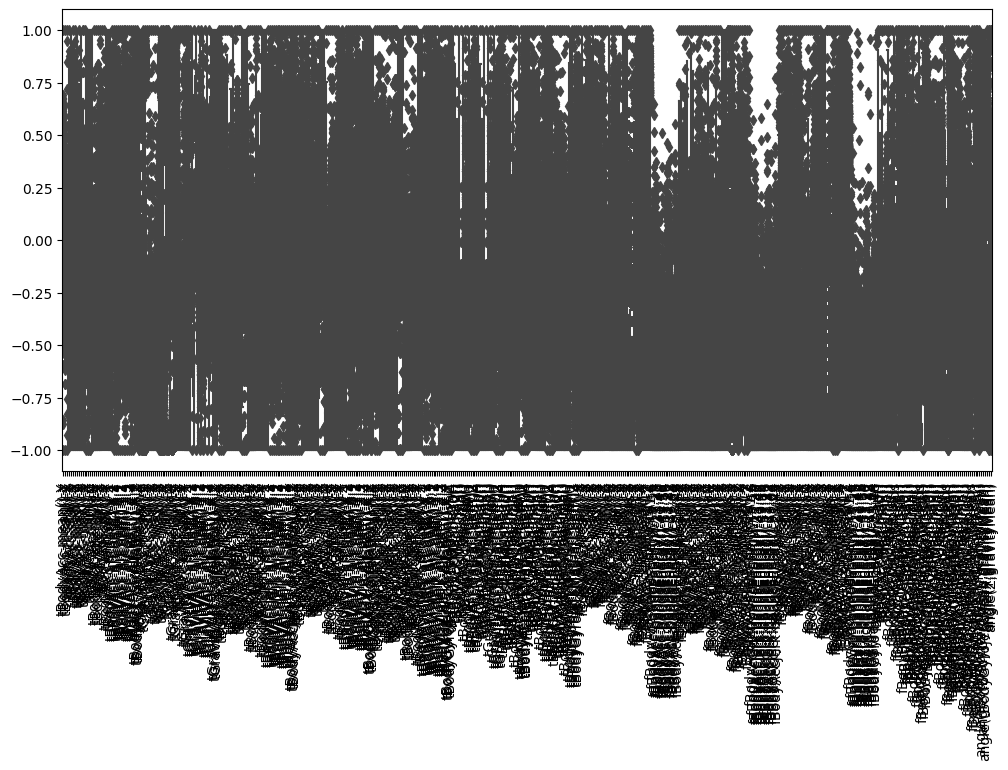

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(data)
plt.xticks(rotation=90)
plt.show()

In [33]:
len(data.columns.tolist())

478

# Feature Reduction

In [34]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X, y = data.iloc[:, :-1], data.iloc[:, -1]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

label_encoder = LabelEncoder()
y_encoded = pd.DataFrame(label_encoder.fit_transform(y), columns=['Activity'])

In [36]:
target_dim = 85

In [37]:
pca = PCA(n_components=target_dim, random_state=42)
data_pca = pca.fit_transform(X_scaled)
X_scaled = data_pca

In [ ]:
# ica = FastICA(n_components=target_dim, random_state=42, max_iter=500)
# data_ica = ica.fit_transform(X_scaled)
# X_scaled = data_ica

In [ ]:
# tsne = TSNE(n_components=target_dim, random_state=42, n_iter=1000, perplexity=30)
# data_tsne = tsne.fit_transform(X_scaled)
# X_scaled = data_tsne

In [38]:
class_counts = y.value_counts()

In [39]:
print(len(class_counts))
class_counts

6


Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

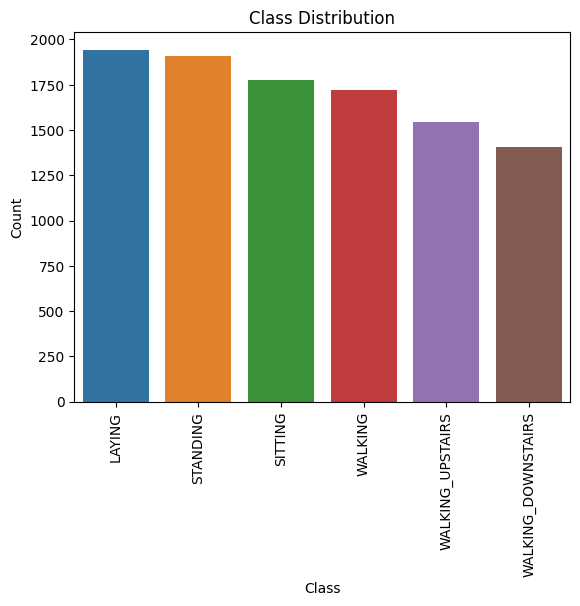

In [40]:
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

In [41]:
list(set(y_encoded.iloc[:, 0]))

[0, 1, 2, 3, 4, 5]

In [ ]:
# X_train, X_test, y_train, y_test = X[:len(train_data)], X[len(train_data):], y_encoded[:len(train_data)], y_encoded[len(train_data):]
# If we take X_scaled data, we get worse accuracy

# XGBoost

In [42]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, stratify=y_encoded, random_state=42)

In [44]:
test_model = xgb.XGBClassifier(num_class=6, random_state=42)
test_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [45]:
pred_train = test_model.predict(X_train)
pred_test = test_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, pred_train)*100)
print("Test Accuracy:", accuracy_score(y_test, pred_test)*100)

Train Accuracy: 100.0
Test Accuracy: 95.33980582524272


# SVM

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, stratify=y_encoded, random_state=42)

svm = SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=42)
svm.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', random_state=42)

In [48]:
pred_train = svm.predict(X_train)
pred_test = svm.predict(X_test)
print("Train accuracy:", accuracy_score(y_train, pred_train)*100)
print("Test accuracy:", accuracy_score(y_test, pred_test)*100)

Train accuracy: 97.68254790264112
Test accuracy: 95.80582524271844


# Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, stratify=y_encoded, random_state=42)

In [59]:
dt = DecisionTreeClassifier(random_state=42)

In [60]:
param = {'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]}

gs = GridSearchCV(dt, param, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [61]:
print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [62]:
accuracy_score(y_test, gs.best_estimator_.predict(X_test))

0.8566990291262135

In [63]:
dt_model = gs.best_estimator_

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

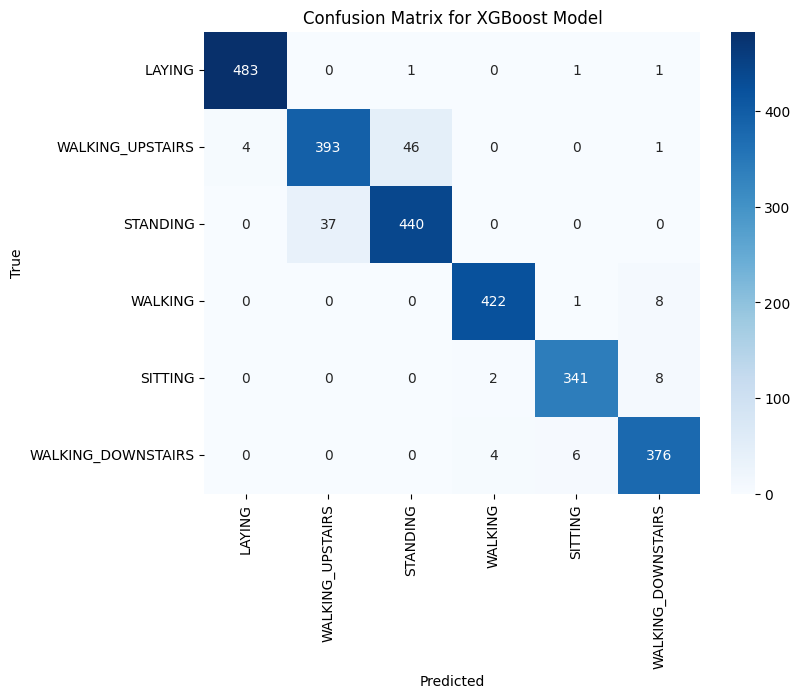

In [68]:
cm = confusion_matrix(y_test, test_model.predict(X_test))

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

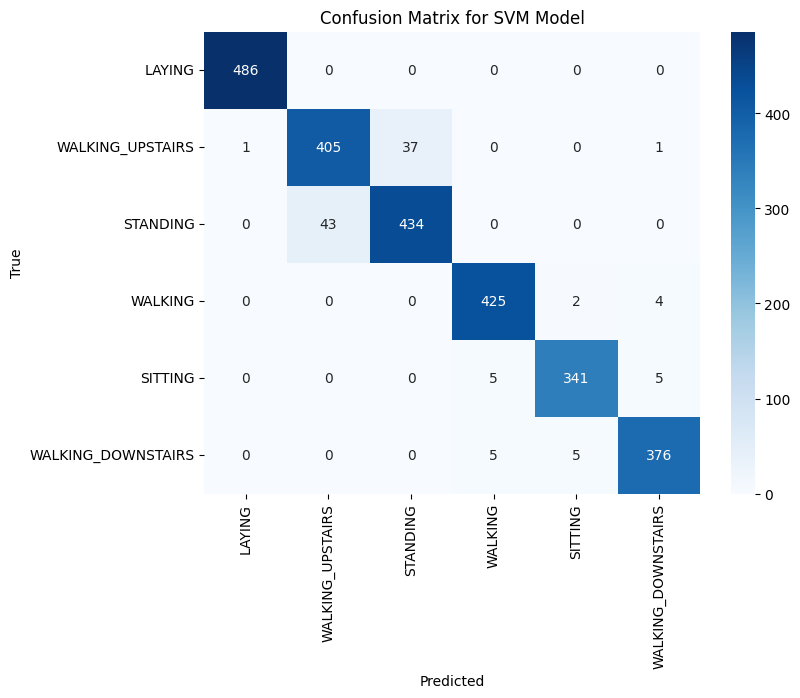

In [69]:
cm = confusion_matrix(y_test, svm.predict(X_test))

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model')
plt.show()

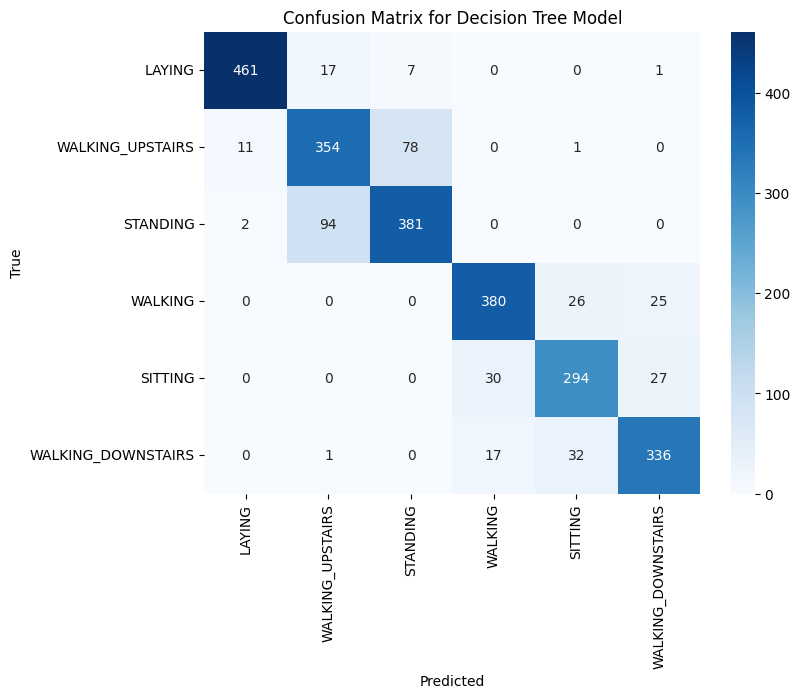

In [70]:
cm = confusion_matrix(y_test, dt_model.predict(X_test))

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

# Saving Models

In [49]:
import pickle

In [50]:
with open('pca_pkl', 'wb') as f:
    pickle.dump(pca, f)
with open('scaler_pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('xgboost_pkl', 'wb') as f:
    pickle.dump(test_model, f)
with open('svm_pkl', 'wb') as f:
    pickle.dump(svm, f)
# with open('dtree_pkl', 'wb') as f:
#     pickle.dump(dt, f)